In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

sys.path.append('../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.keypoint import body
from common.default import PASSING_DEFAULT
from common.video import Capture
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.73it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 16.49it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.92it/s]


# nanが存在しない、かつ、起立しているkeypointsを抽出

In [84]:
def get_frame_max_coor(room_num, date):
    video_path = os.path.join(common.root, 'video', room_num, date, '01.mp4')
    cap = Capture(video_path)
    frame = cap.read()
    max_coor = frame.shape[:2]
    return max_coor[1::-1]

max_coors = {}
for setting in data_settings:
    max_coors[setting['room_num']] = get_frame_max_coor(setting['room_num'], setting['date'])

In [85]:
def is_stand_up(kps, ratio=1.2):
    lsh = kps[body['LShoulder']]
    rsh = kps[body['RShoulder']]
    lhp = kps[body['LHip']]
    rhp = kps[body['RHip']]
    lakl = kps[body['LAnkle']]
    rakl = kps[body['RAnkle']]
    
    s_mdl = np.mean([lsh, rsh], axis=0)
    h_mdl = np.mean([lhp, rhp], axis=0)
    a_mdl = np.mean([lakl, rakl], axis=0)
    
    trunk = h_mdl - s_mdl
    
    if np.all(h_mdl + trunk * ratio < a_mdl):
        return True
    else:
        return False

In [86]:
keypoints_lst = []
for key, ind in individuals.items():
    room_num = key.split('_')[0]
    kps_dict = ind.keypoints  # {frame_num: keypoints}
    if len(kps_dict) < 30:
        # skip too short data
        continue
    for kps in kps_dict.values():
        if True not in np.isnan(kps) and is_stand_up(kps):
            # normalize
            kps = np.array(kps) / max_coors[room_num]
            
            keypoints_lst.append(kps)

print(len(keypoints_lst))

25758


# 学習

In [87]:
# network config
net_config = {
    'n_features': 4 * 2,
    'n_layers': 3,
    'hidden_dims': [128, 128, 8],
    'dropouts': [0.5, 0.1, 0.],
    'output_dim': 2,
    'device': device,
}

# leraning rate
LR = 0.1

# training and data settings
EPOCH = 100
BATCH_SIZE = 1024 * 8
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット作成

In [105]:
class MyDataset(Dataset):
    def __init__(self, keypoints_lst, indices, **config):
        self.x, self.y = [], []
        for idx in tqdm(indices):
            kps = keypoints_lst[idx]
            self.x.append([
                kps[body['LShoulder']],
                kps[body['RShoulder']],
                kps[body['LHip']],
                kps[body['RHip']],
            ])
            self.y.append(
                np.mean([kps[body['LAnkle']], kps[body['RAnkle']]], axis=0)
            )
        self.x = np.array(self.x).reshape(-1, config['n_features'])
        self.y = np.array(self.y).reshape(-1, config['output_dim'])
            
        self.device = config['device']
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            tensor(self.y[index]).float().to(self.device)
        )

    def __len__(self):
        return len(self.x)

In [106]:
random_idxs = np.random.choice(
    range(len(keypoints_lst)),
    size=len(keypoints_lst),
    replace=False
)
train_len = int(len(keypoints_lst) * TRAIN_RATIO)
val_len = int(len(keypoints_lst) * VAL_RATIO)

train_idxs = random_idxs[:train_len]
val_idxs = random_idxs[train_len:train_len + val_len]
test_idxs = random_idxs[train_len + val_len:]

train_dataset = MyDataset(keypoints_lst, train_idxs, **net_config)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
val_loader = DataLoader(
    MyDataset(keypoints_lst, val_idxs, **net_config), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    MyDataset(keypoints_lst, test_idxs, **net_config), batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18030/18030 [00:00<00:00, 104057.69it/s]


18030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5153/5153 [00:00<00:00, 76912.19it/s]


## モデル作成

In [107]:
class Network(nn.Module):
    def __init__(self, **config):
        super(Network, self).__init__()
        self.n_features = config['n_features']
        self.n_layers = config['n_layers']
        self.hidden_dims = config['hidden_dims']
        self.output_dim = config['output_dim']
        self.dropouts = config['dropouts']
        
        assert\
            self.n_layers == len(self.hidden_dims),\
            f'n_layers:{self.n_layers}, n_hidden_dims:{len(self.hidden_dims)}'
        
        assert\
            self.n_layers == len(self.dropouts),\
            f'n_layers:{self.n_layers}, n_dropouts:{len(self.dropouts)}'
        
        
        self.net = nn.Sequential()
        for i in range(self.n_layers):
            if i == 0:
                in_dim = self.n_features
            else:
                in_dim = self.hidden_dims[i - 1]
            out_dim = self.hidden_dims[i]
            self.net.add_module(
                f'fc{i + 1}',
                Layer(in_dim, out_dim, self.dropouts[i])
            )
        self.output_layer = nn.Linear(self.hidden_dims[-1], self.output_dim)
    
    def forward(self, x):
        x = self.net(x)
        x = self.output_layer(x)
        return x.reshape(-1, self.output_dim)

        
class Layer(nn.Sequential):
    def __init__(self, in_dims, out_dims, dropout_rate):
        super(Layer, self).__init__(
            nn.Linear(in_dims, out_dims),
            nn.BatchNorm1d(out_dims),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

In [108]:
model = None
model = Network(**net_config)
model.to(device)
model

Network(
  (net): Sequential(
    (fc1): Layer(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
    )
    (fc2): Layer(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
    )
    (fc3): Layer(
      (0): Linear(in_features=128, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
  (output_layer): Linear(in_features=8, out_features=2, bias=True)
)

In [109]:
criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

## 学習

In [110]:
history = dict(train=[], val=[])
for epoch in range(1, EPOCH + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    lr = optimizer.param_groups[0]['lr']
    for x, y in train_loader:
        optimizer.zero_grad()
        x = model(x)

        loss = criterion(x, y)
        loss.backward()
        train_losses.append(loss.item())
        
        optimizer.step()

    scheduler.step()

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            x = model(x)
            loss = criterion(x, y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{(EPOCH)}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, lr: {lr:.5f}, time: {te - ts:.2f}")

Epoch[1/100] train loss: 0.24400, val loss: 8.55956, lr: 0.10000, time: 4.26
Epoch[2/100] train loss: 0.03644, val loss: 0.99521, lr: 0.09500, time: 3.22
Epoch[3/100] train loss: 0.02355, val loss: 0.22562, lr: 0.09025, time: 3.28
Epoch[4/100] train loss: 0.02142, val loss: 0.26564, lr: 0.08574, time: 4.30
Epoch[5/100] train loss: 0.01855, val loss: 0.19591, lr: 0.08145, time: 3.08
Epoch[6/100] train loss: 0.01706, val loss: 0.10244, lr: 0.07738, time: 3.29
Epoch[7/100] train loss: 0.01694, val loss: 0.05232, lr: 0.07351, time: 3.81
Epoch[8/100] train loss: 0.01563, val loss: 0.02924, lr: 0.06983, time: 3.20
Epoch[9/100] train loss: 0.01400, val loss: 0.01904, lr: 0.06634, time: 3.25
Epoch[10/100] train loss: 0.01326, val loss: 0.01507, lr: 0.06302, time: 3.85
Epoch[11/100] train loss: 0.01264, val loss: 0.01407, lr: 0.05987, time: 3.33
Epoch[12/100] train loss: 0.01202, val loss: 0.01321, lr: 0.05688, time: 3.86
Epoch[13/100] train loss: 0.01143, val loss: 0.01125, lr: 0.05404, time: 

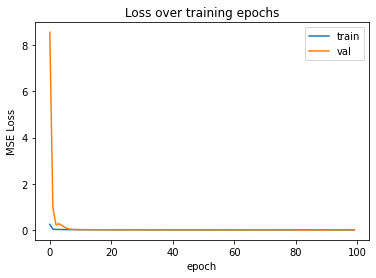

In [111]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

In [112]:
path = f'{common.root}/model/keypoints_occlusion.pth'
torch.save(model, path)

## 検証

In [113]:
path = f'{common.root}/model/keypoints_occlusion.pth'
model = torch.load(path)
model = model.to(device)

In [114]:
losses = []
with torch.no_grad():
    model = model.eval()
    for x, y in test_loader:
        x = model(x)
        loss = criterion(x, y)
        losses.append(loss.item())

0.0023635264951735735


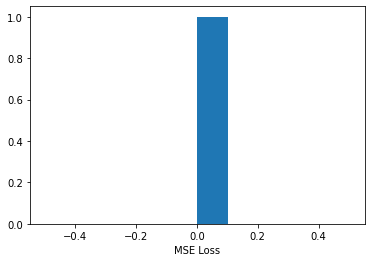

In [115]:
print(np.mean(losses))
plt.hist(losses)
plt.xlabel('MSE Loss')
plt.show()

In [116]:
graph = [
    # ========== 4 ============ 9 =========== 14 =====
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Nose
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEye
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REye
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEar
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REar
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # LShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # RShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # LElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # RElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # LHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # RHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # LKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # RKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LAnkle
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RAnkle
]

def plot_keypoints(img, keypoints, color=(255, 0, 0)):
    if np.any(np.isnan(keypoints)):
        return img
    keypoints = np.array(keypoints)
    for i in range(len(keypoints) - 1):
        for j in range(i + 1, len(keypoints)):
            p1 = tuple(keypoints[i].astype(int))
            p2 = tuple(keypoints[j].astype(int))
            if graph[i][j] == 1:
                img = cv2.line(img, p1, p2, color, 3)
    return img

def plot_prediction(img, y, color=(0, 255, 0)):
    for pt in y:
        pt = tuple(pt.astype(int))
        img = cv2.circle(img, pt, 10, color, -1)
    return img

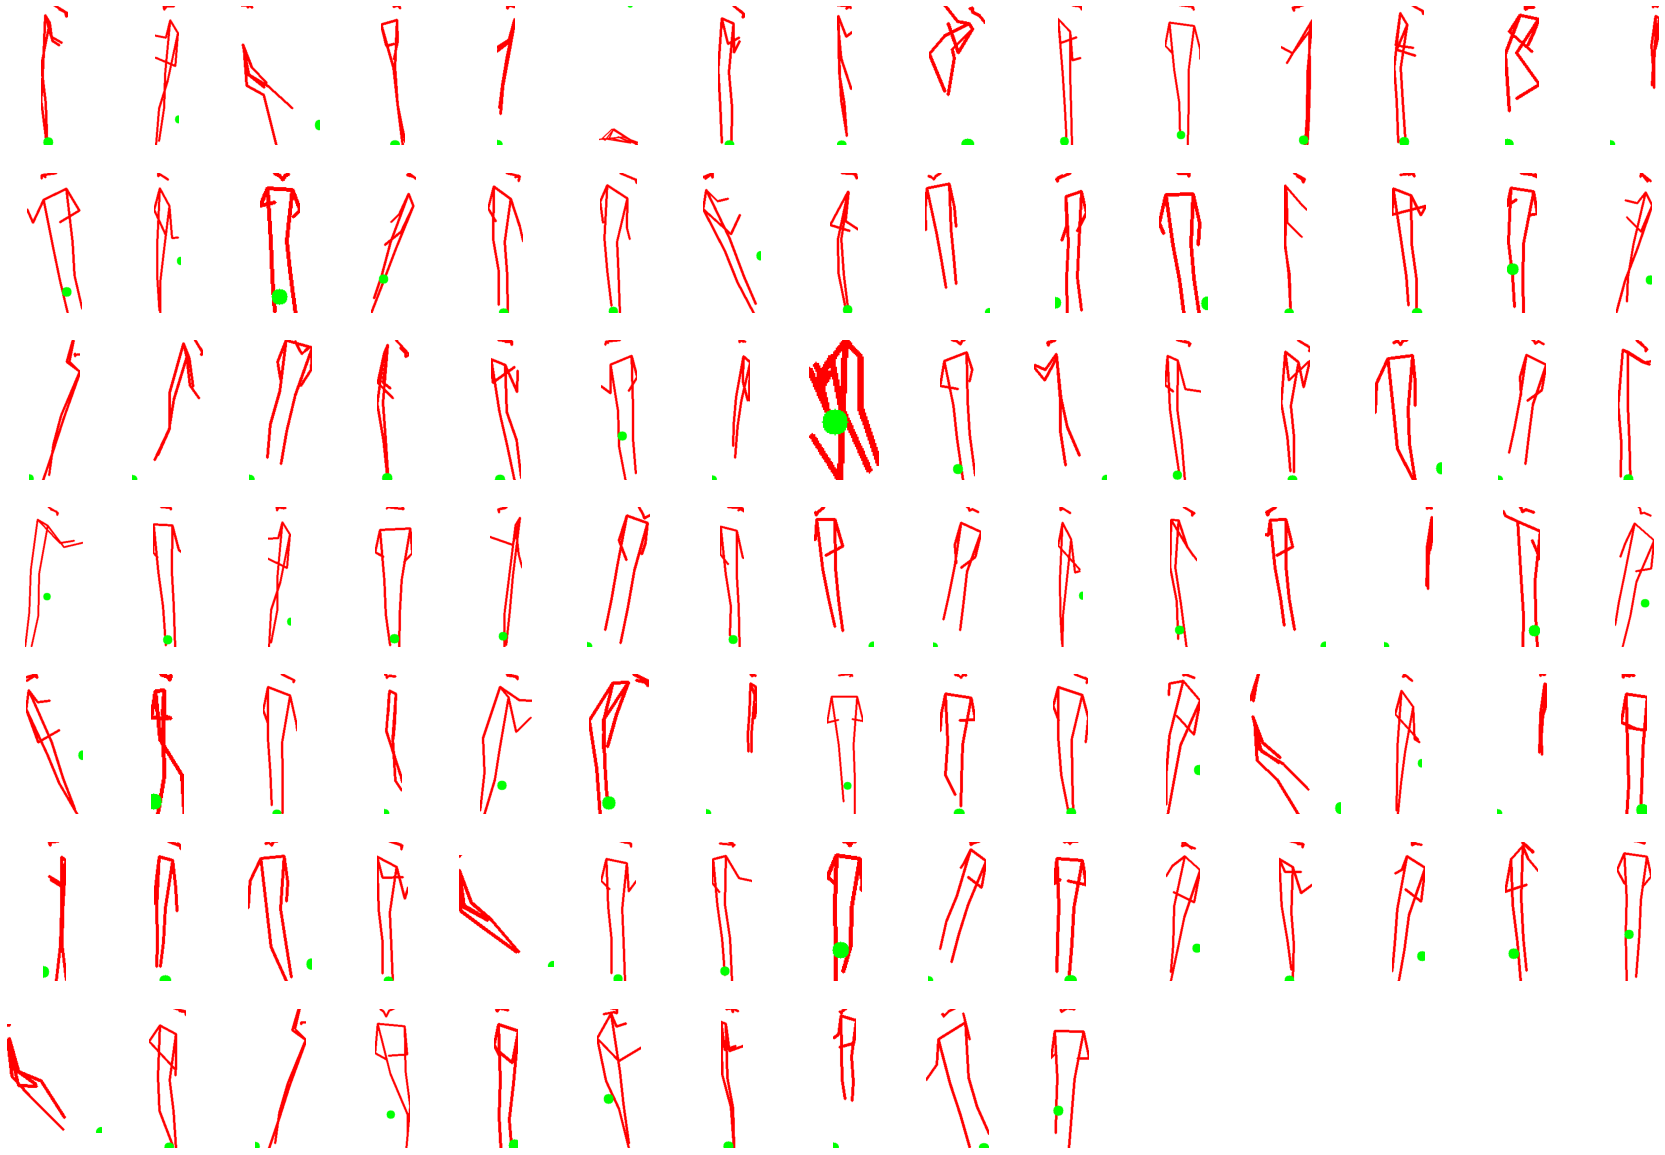

In [118]:
test_len = 100

col_len = 15
row_len = test_len // col_len + 1

model.eval()
with torch.no_grad():
    fig = plt.figure(figsize=(col_len * 2, row_len * 3))
    for i, idx in enumerate(test_idxs[:test_len]):
        kps = keypoints_lst[idx]
        x = [
            kps[body['LShoulder']],
            kps[body['RShoulder']],
            kps[body['LHip']],
            kps[body['RHip']],
        ]
        x = np.array(x).flatten()
        x = tensor([x]).float().to(device)
        y = model(x)
        y = y.cpu().numpy().reshape(-1, 2)
        
        kps = kps * 1000
        y = y * 1000
        data = kps.tolist() + y.tolist()
        
        mins = np.min(data, axis=0)
        size = (np.max(data, axis=0) - mins).astype(int)
        img = np.ones((size[1], size[0], 3), np.uint8) * 255
        
        img = plot_keypoints(img, kps - mins)
        img = plot_prediction(img, y - mins)
        
        ax = fig.add_subplot(row_len, col_len, i + 1)
        ax.imshow(img)
        ax.axis('off')
        
    plt.show()